# <center> Sequential Data-Consistent Inversion - ADCIRC Example </center>
___
<font color='blue'><center>**Carlos del-Castillo-Negrete, Rylan Spence**</center></font>
    <br>
    <center>University of Texas at Austin
    <br>
    carlos.delcastillo@utexas.edu, rylan.spence@utexas.edu</center>
___

TODO:
- Add citation for paper


## Getting dataset

If running from within DesignSafe, data should be under the project directory PRJ-3492 at the path `~/NHERI-Published/PRJ-3492/` in your jupyter instance.

Otherwise [download published dataset](https://doi.org/10.17603/ds2-bmrf-y737) and place in same path as this notebook.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pydci import PCAMUDProblem
from pydci.examples import adcirc as ad
from pydci.utils import get_df
from pydci.log import disable_log, enable_log, logger

In [2]:
path_ds = Path.home() / "NHERI-Published/PRJ-3492/si-inlet-full-ds.pickle"
path_local = Path.cwd() / "si-inlet-full-ds.pickle"
ds_path = path_ds
if not path_ds.exists():
    if not path_local.exists():
        raise FileNotFoundError("Dataset not found")
    ds_path = path_local

full_ds = ad.load_full_ds(ds_path)

In [3]:
full_ds[0][-1]

array([0.06724306, 0.00256819])

In [4]:
std_dev = 0.05
seed = 21

In [5]:
ret = ad.build_ds(data=full_ds, seed=seed, std_dev=std_dev, outpath="pydci_si_example")

data_df = ret["data"]
data_df

,ts,shift_idx,sample_flag,lam_true_0,lam_true_1,q_lam_true_0,q_lam_obs_0
0,2018-01-01 00:03:00,0,True,0.067243,0.002568,-0.160002,-0.162600
1,2018-01-01 00:06:00,0,True,0.067243,0.002568,-0.159192,-0.164751
2,2018-01-01 00:09:00,0,True,0.067243,0.002568,-0.158108,-0.106019
3,2018-01-01 00:12:00,0,True,0.067243,0.002568,-0.156425,-0.219262
4,2018-01-01 00:15:00,0,True,0.067243,0.002568,-0.154186,-0.116916
...,...,...,...,...,...,...,...
6128,2018-01-13 23:45:00,0,True,0.067243,0.002568,-0.156296,-0.126368
6129,2018-01-13 23:48:00,0,True,0.067243,0.002568,-0.167302,-0.212053
6130,2018-01-13 23:51:00,0,True,0.067243,0.002568,-0.178476,-0.254657
6131,2018-01-13 23:54:00,0,True,0.067243,0.002568,-0.189576,-0.240698


In [6]:
samples_df = ret["samples"]
samples_df

,lam_0,lam_1,q_lam_0,q_lam_1,q_lam_2,q_lam_3,q_lam_4,q_lam_5,q_lam_6,q_lam_7,...,q_lam_6123,q_lam_6124,q_lam_6125,q_lam_6126,q_lam_6127,q_lam_6128,q_lam_6129,q_lam_6130,q_lam_6131,q_lam_6132
0,0.093865,0.002217,-0.098529,-0.098187,-0.097603,-0.096297,-0.094471,-0.092910,-0.092280,-0.092804,...,-0.031317,-0.040351,-0.050015,-0.060054,-0.070415,-0.081188,-0.092421,-0.103996,-0.115751,-0.127697
1,0.073952,0.002513,-0.149888,-0.149366,-0.148671,-0.147051,-0.144599,-0.142349,-0.141211,-0.141387,...,-0.096050,-0.105088,-0.114628,-0.124460,-0.134574,-0.145131,-0.156176,-0.167739,-0.179283,-0.191110
2,0.059847,0.001664,0.009024,0.009842,0.010425,0.010887,0.011452,0.011629,0.010814,0.008978,...,0.088413,0.079203,0.069547,0.059593,0.049343,0.038682,0.027550,0.016001,0.004138,-0.007969
3,0.040349,0.001561,0.030676,0.031019,0.031184,0.031288,0.031271,0.030790,0.029591,0.027613,...,0.109560,0.100329,0.090722,0.080934,0.070816,0.060206,0.049101,0.037551,0.025542,0.013429
4,0.049240,0.003691,-0.115084,-0.112887,-0.110688,-0.107900,-0.104600,-0.101529,-0.099412,-0.098575,...,-0.053479,-0.063066,-0.073423,-0.084119,-0.095033,-0.106318,-0.118181,-0.130594,-0.143590,-0.156585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0.055597,0.002976,-0.150908,-0.148516,-0.146042,-0.142579,-0.138269,-0.134226,-0.131524,-0.130446,...,-0.096083,-0.105813,-0.116276,-0.127136,-0.138285,-0.149806,-0.161832,-0.174512,-0.187535,-0.200639
994,0.060459,0.002982,-0.180696,-0.177620,-0.174413,-0.170387,-0.165490,-0.160565,-0.157006,-0.155492,...,-0.128567,-0.137712,-0.147994,-0.159056,-0.170856,-0.183221,-0.195793,-0.208266,-0.221700,-0.235379
995,0.049044,0.002823,-0.113886,-0.111741,-0.109616,-0.106887,-0.103613,-0.100548,-0.098421,-0.097572,...,-0.051925,-0.061532,-0.071904,-0.082644,-0.093631,-0.104994,-0.116927,-0.129399,-0.142426,-0.155378
996,0.036092,0.002299,-0.036399,-0.034519,-0.032745,-0.030712,-0.028603,-0.027022,-0.026373,-0.026784,...,0.038204,0.028407,0.017975,0.007227,-0.003762,-0.015099,-0.026851,-0.038969,-0.051372,-0.064029


In [7]:
lam_ref = get_df(data_df, "lam_true", size=2)[0]
lam_ref

array([0.06724306, 0.00256819])

# Time Window 3

<Axes: xlabel='Time', ylabel='Water Elevation (m)'>

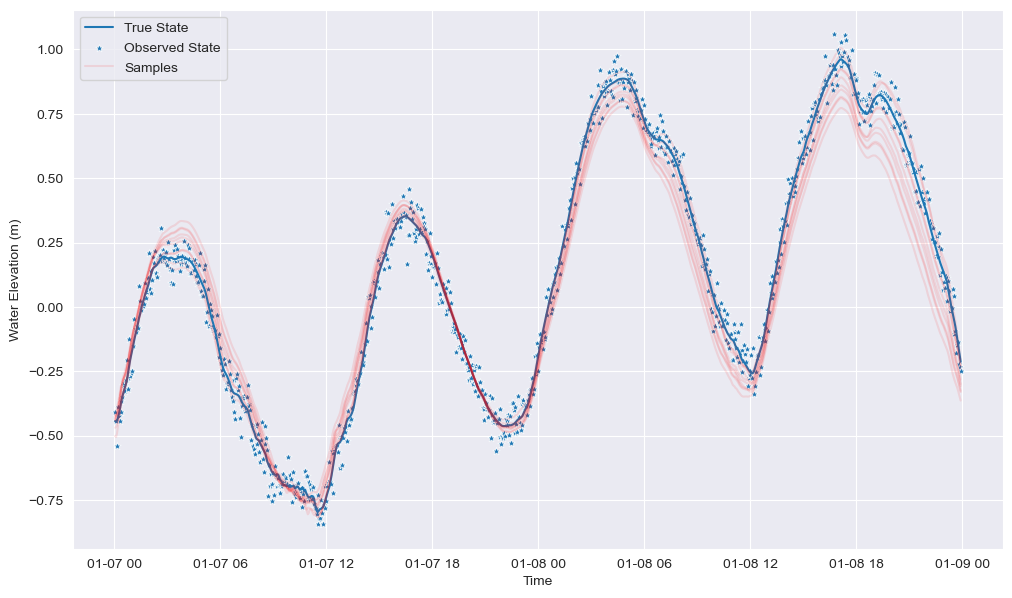

In [8]:
t3 = ["2018-01-07 00:00:00", "2018-01-09 00:00:00"]
t3_mask = data_df.index[(data_df["ts"] > t3[0]) & (data_df["ts"] < t3[1])].values
t3_mask = range(min(t3_mask), max(t3_mask))

ad.plot_state(data_df, samples_df, t3_mask)

### Solving Using $Q_{PCA}$ Map

In [9]:
pca = PCAMUDProblem(samples_df, data_df, std_dev)
pca.set_weights([])
pca.solve(pca_components=[0, 1], pca_mask=t3_mask)
pca.result

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask
0,0.908784,5.935119,0.069212,0.002584,439,"[0, 1]","range(2774, 3732)"


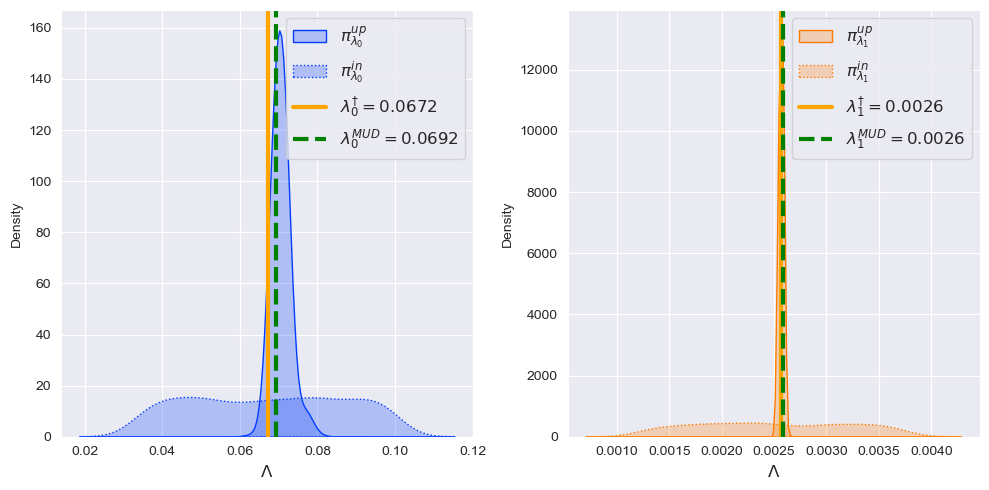

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
pca.plot_L(param_idx=0, lam_true=[lam_ref], ax=ax[0])
pca.plot_L(param_idx=1, lam_true=[lam_ref], ax=ax[1])
plt.savefig("adcirc_lam_density_no_split.png")

## Using 2, 5, 10 splits

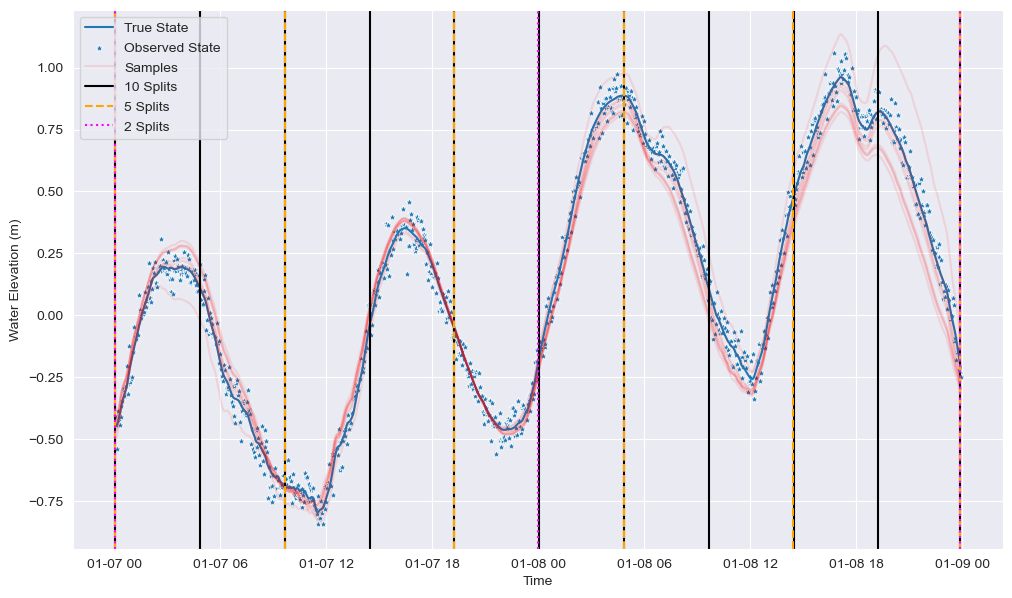

In [41]:
def split_range(mask, n_splits):
    return [range(x[0], x[-1]) for x in np.array_split(mask, n_splits)]


intervals_2 = split_range(t3_mask, 2)
intervals_5 = split_range(t3_mask, 5)
intervals_10 = split_range(t3_mask, 10)

plot_intervals = [
    ("10 Splits", {"color": "black", "linestyle": "-"}, intervals_10),
    ("5 Splits", {"color": "orange", "linestyle": "--"}, intervals_5),
    ("2 Splits", {"color": "magenta", "linestyle": ":"}, intervals_2),
]

ad.plot_state(data_df, samples_df, t3_mask, plot_intervals=plot_intervals)
plt.savefig("adcirc_time_window_splits.png")

In [12]:
pca_2 = PCAMUDProblem(samples_df, data_df, std_dev)
pca_2.solve_it(pca_mask=t3_mask, pca_splits=2, pca_components=[[0]], exp_thresh=1e10)
pca_2.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i
0,0.928730,2.532213,0.078406,0.002391,251,[0],"range(2774, 3252)",0
0,0.836582,1.797336,0.056920,0.003015,592,[0],"range(3253, 3731)",1


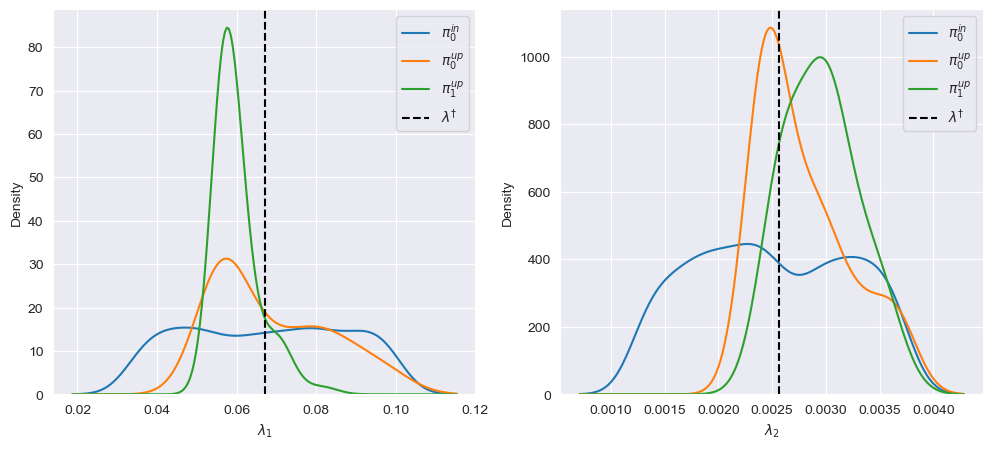

In [13]:
ad.plot_iterations(pca_2, plot_idxs=[0, 1], lam_true=lam_ref)
plt.savefig("adcirc_lam_density_2_splits.png")

In [14]:
pca_5 = PCAMUDProblem(samples_df, data_df, std_dev)
pca_5.solve_it(pca_mask=t3_mask, pca_splits=5, pca_components=[[0]], exp_thresh=0.9)
pca_5.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i
0,1.103372,2.267444,0.050972,0.002684,683,[0],"range(2774, 2965)",0
0,0.362617,1.902927,0.061655,0.002603,44,[0],"range(2966, 3157)",1
0,1.044103,0.631633,0.061655,0.002603,44,[0],"range(3158, 3349)",2
0,1.078720,0.208857,0.061655,0.002603,44,[0],"range(3350, 3540)",3
0,1.703029,0.842448,0.061655,0.002603,44,[0],"range(3541, 3731)",4


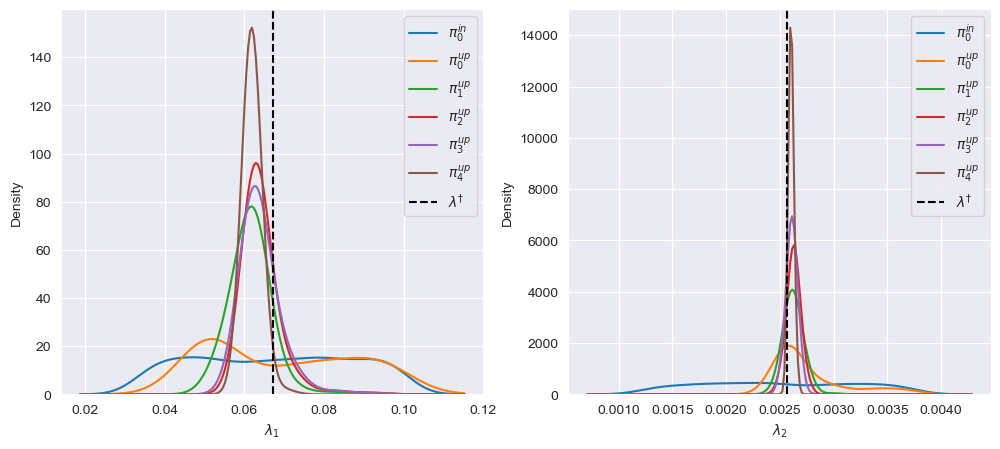

In [15]:
ad.plot_iterations(pca_5, plot_idxs=range(5), lam_true=lam_ref)
plt.savefig("adcirc_lam_density_5_splits.png")

In [16]:
pca_10 = PCAMUDProblem(samples_df, data_df, std_dev)
pca_10.solve_it(pca_mask=t3_mask, pca_splits=10, pca_components=[[0]], exp_thresh=0.9)
pca_10.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i
0,1.136705,1.590017,0.082026,0.002509,838,[0],"range(2774, 2869)",0
0,0.944434,1.078154,0.087825,0.002599,12,[0],"range(2870, 2965)",1
0,0.874750,1.346504,0.063742,0.002642,377,[0],"range(2966, 3061)",2
0,0.650789,1.275633,0.063742,0.002642,377,[0],"range(3062, 3157)",3
0,0.726864,0.696077,0.063742,0.002642,377,[0],"range(3158, 3253)",4
0,0.734823,0.600740,0.063742,0.002642,377,[0],"range(3254, 3349)",5
0,0.824814,0.688581,0.071724,0.002557,877,[0],"range(3350, 3445)",6
0,1.329209,0.285471,0.071724,0.002557,877,[0],"range(3446, 3541)",7
0,0.895068,1.882746,0.063742,0.002642,377,[0],"range(3542, 3636)",8
0,0.453210,0.729061,0.063742,0.002642,377,[0],"range(3637, 3731)",9


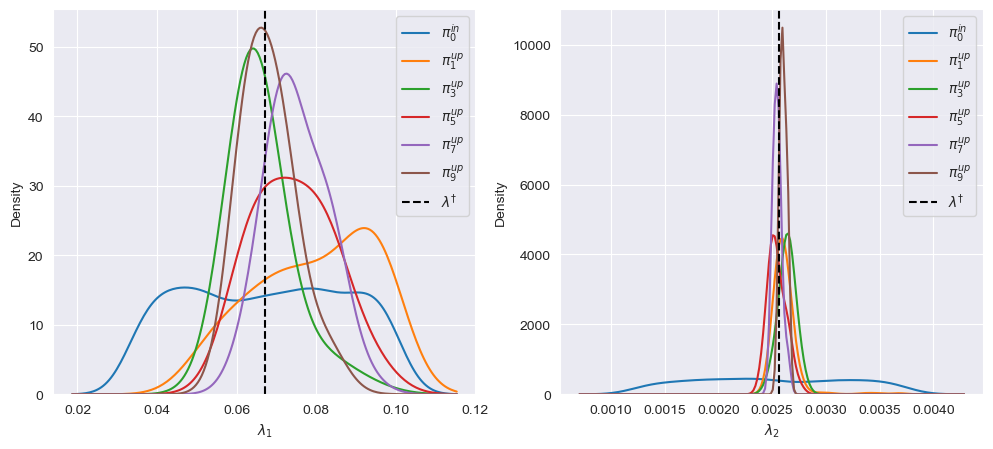

In [17]:
ad.plot_iterations(pca_10, plot_idxs=range(1, 10, 2), lam_true=lam_ref)
plt.savefig("adcirc_lam_density_10_splits.png")

In [46]:
pca_100 = PCAMUDProblem(samples_df, data_df, std_dev)
pca_100.solve_it(
    pca_mask=t3_mask, pca_splits=100, pca_components=[[0]], exp_thresh=1e10
)
pca_100.it_results

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i
0,0.940010,0.734217,0.045694,0.002448,741,[0],"range(2774, 2783)",0
0,0.632921,0.070876,0.043783,0.002889,368,[0],"range(2784, 2793)",1
0,0.651028,1.813860,0.037988,0.002950,893,[0],"range(2794, 2803)",2
0,0.860919,0.578388,0.040309,0.002846,142,[0],"range(2804, 2813)",3
0,0.947964,0.516069,0.074917,0.003509,352,[0],"range(2814, 2823)",4
...,...,...,...,...,...,...,...,...
0,0.170446,6.781930,0.063742,0.002642,377,[0],"range(3687, 3695)",95
0,0.933248,0.255453,0.063742,0.002642,377,[0],"range(3696, 3704)",96
0,0.865401,0.240057,0.063742,0.002642,377,[0],"range(3705, 3713)",97
0,0.784806,0.467817,0.063742,0.002642,377,[0],"range(3714, 3722)",98


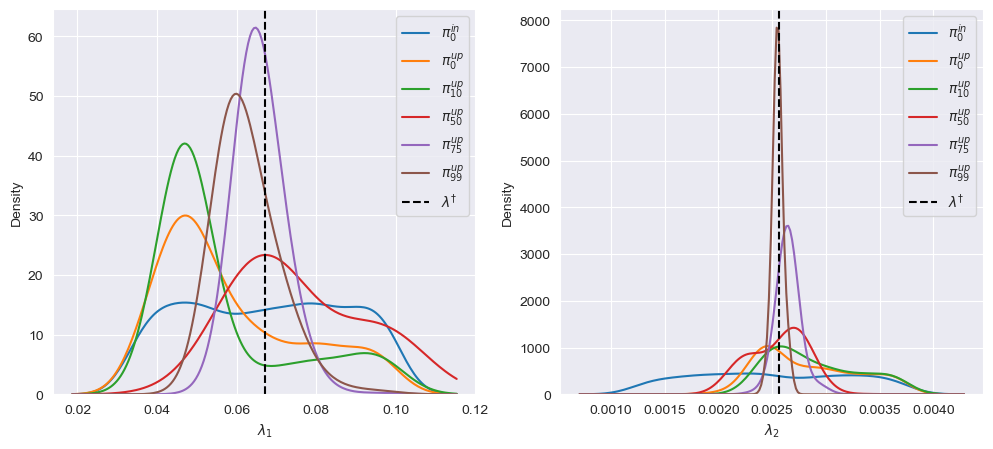

In [19]:
ad.plot_iterations(pca_100, plot_idxs=[0, 10, 50, 75, 99], lam_true=lam_ref)
plt.savefig("adcirc_lam_density_100_splits.png")

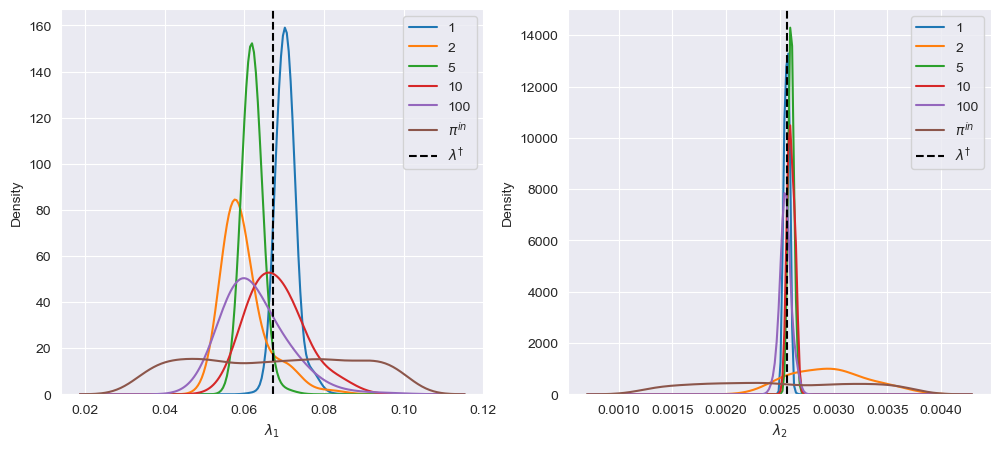

In [57]:
def compare_final_solutions(probs, lam_true=None):
    """
    Plot updated marginal distributions for each parameter for each iteration.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    for prob in probs:
        n_its = 1
        if "it_results" in dir(prob):
            n_its = len(prob.it_results)
        label = f"{n_its}"
        sns.kdeplot(
            prob.state,
            x="lam_0",
            weights=prob.state["weight"] * prob.state["ratio"],
            ax=ax[0],
            label=label,
        )
        sns.kdeplot(
            prob.state,
            x="lam_1",
            weights=prob.state["weight"] * prob.state["ratio"],
            ax=ax[1],
            label=label,
        )

    label = f"$\pi^{{in}}$"
    sns.kdeplot(probs[0].state, x="lam_0", ax=ax[0], label=label)
    sns.kdeplot(probs[0].state, x="lam_1", ax=ax[1], label=label)
    if lam_true is not None:
        ax[0].axvline(
            lam_true[0], color="k", linestyle="--", label=f"$\lambda^{{\dagger}}$"
        )
        ax[1].axvline(
            lam_true[1], color="k", linestyle="--", label=f"$\lambda^{{\dagger}}$"
        )

    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel("$\lambda_1$")
    ax[1].set_xlabel("$\lambda_2$")

    return ax


ax = plot_iterations([pca, pca_2, pca_5, pca_10, pca_100], lam_true=lam_ref)
plt.savefig("adcirc_lam_split_pi_up_comparison.png")

## Comparing Sequential vs. Fixed Over Time

We will compare the results of the sequential inversion with the fixed inversion over time.
We will use the same number of intervals for both cases.

In [25]:
NS = 10
NT = 20
NSAMPLES = 999

args = {
    "ds": full_ds,
    "mask": t3_mask,
    "num_splits": NS,
    "std_dev": std_dev,
    "num_trials": NT,
    "num_samples": NSAMPLES,
    "pca_components": [[0]],
}

disable_log()
results = []
results.append(ad.iterative_trials(**args))
results.append(ad.fixed_trials(**args))
args["pca_components"] = [[0, 1]]
results.append(ad.fixed_trials(**args))

Iterative (nc = 1) |████████████████████| 20/20 [100%] in 13.7s (1.44/s)        
Full (nc = 1) |████████████████████| 200/200 [100%] in 49.9s (4.00/s)           
Full (nc = 2) |████████████████████| 200/200 [100%] in 46.0s (4.34/s)           


In [26]:
results[0]

,e_r,kl,lam_MUD_0,lam_MUD_1,MUD_idx,pca_components,pca_mask,i,l2_err,state_err,ts,max_it,num_iters,trial,type
0,1.109871,1.567297,0.081713,0.002543,599,[0],"range(2774, 2869)",0,0.014469,4.067848,2018-01-07 00:03:00,10,10,0,iterative ($\ell$ = 1)
0,1.109871,1.567297,0.081713,0.002543,599,[0],"range(2774, 2869)",1,0.014469,4.067848,2018-01-07 04:48:00,10,10,0,iterative ($\ell$ = 1)
0,0.932596,1.151008,0.090840,0.002658,423,[0],"range(2870, 2965)",2,0.023598,4.634764,2018-01-07 09:36:00,10,10,0,iterative ($\ell$ = 1)
0,0.858604,0.860618,0.094254,0.002605,654,[0],"range(2966, 3061)",3,0.027011,4.216726,2018-01-07 14:24:00,10,10,0,iterative ($\ell$ = 1)
0,1.275900,0.573274,0.063394,0.002738,905,[0],"range(3062, 3157)",4,0.003853,5.769507,2018-01-07 19:12:00,10,10,0,iterative ($\ell$ = 1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.129158,0.780013,0.056247,0.002641,788,[0],"range(3062, 3157)",4,0.010996,4.427428,2018-01-07 19:12:00,8,10,19,iterative ($\ell$ = 1)
0,0.480482,3.492516,0.056247,0.002641,788,[0],"range(3158, 3253)",5,0.010996,4.427428,2018-01-08 00:00:00,8,10,19,iterative ($\ell$ = 1)
0,0.446465,1.209228,0.063394,0.002738,815,[0],"range(3254, 3349)",6,0.003853,5.767829,2018-01-08 04:48:00,8,10,19,iterative ($\ell$ = 1)
0,0.792187,1.359671,0.071724,0.002557,102,[0],"range(3350, 3445)",7,0.004481,4.015633,2018-01-08 09:36:00,8,10,19,iterative ($\ell$ = 1)


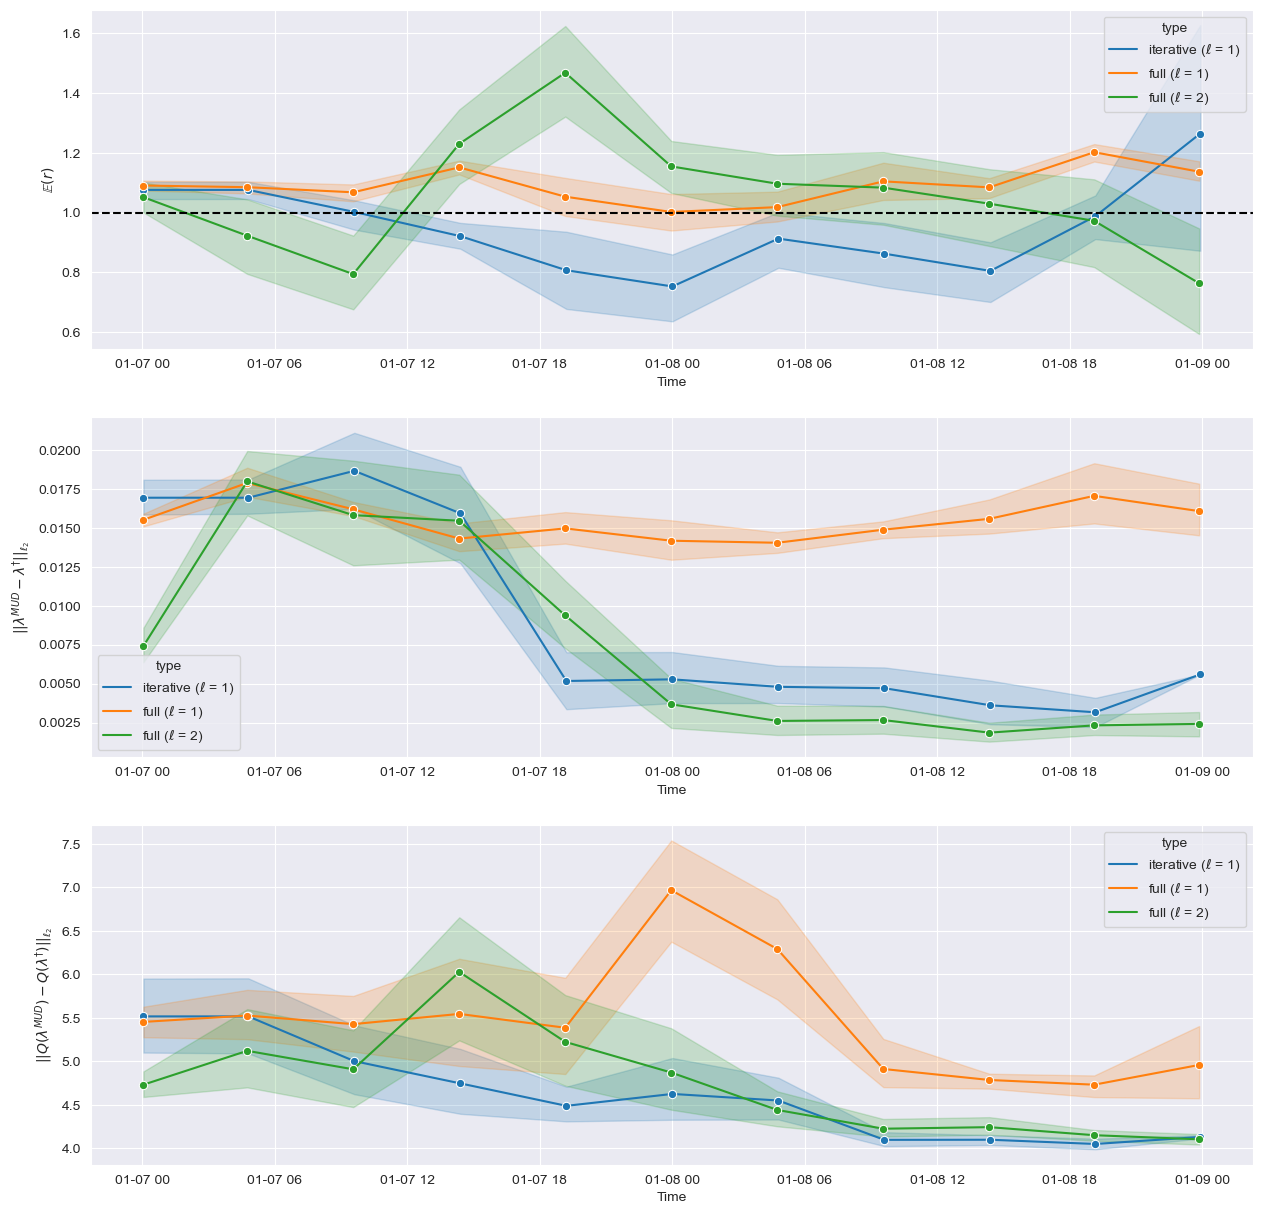

In [27]:
plot_args = {"markers": True, "hue": "type", "marker": "o"}
ax = ad.plot_metric(
    results,
    metric=["e_r", "l2_err", "state_err"],
    figsize=(15, 15),
    lineplot_kwargs=plot_args,
)
plt.savefig("adcirc_trials.png")

## Using Less Samples

In [32]:
disable_log()

NSAMPLES = 100
args = {
    "ds": full_ds,
    "mask": t3_mask,
    "num_splits": NS,
    "std_dev": std_dev,
    "num_trials": NT,
    "num_samples": NSAMPLES,
    "pca_components": [[0]],
}

results_100 = []
results_100.append(ad.iterative_trials(**args))
results_100.append(ad.fixed_trials(**args))
args["pca_components"] = [[0, 1]]
results_100.append(ad.fixed_trials(**args))

Iterative (nc = 1) |████████████████████| 20/20 [100%] in 7.6s (2.58/s)         
Full (nc = 1) |████████████████████| 200/200 [100%] in 38.6s (5.20/s)           |████████▋           | ▄▆█ 86/200 [43%] in 15s (~20s, 5.6/s) |██████████████▏     | ▁▃▅ 141/200 [70%] in 26s (~11s, 5.4/s) 
Full (nc = 2) |████████████████████| 200/200 [100%] in 36.7s (5.43/s)           


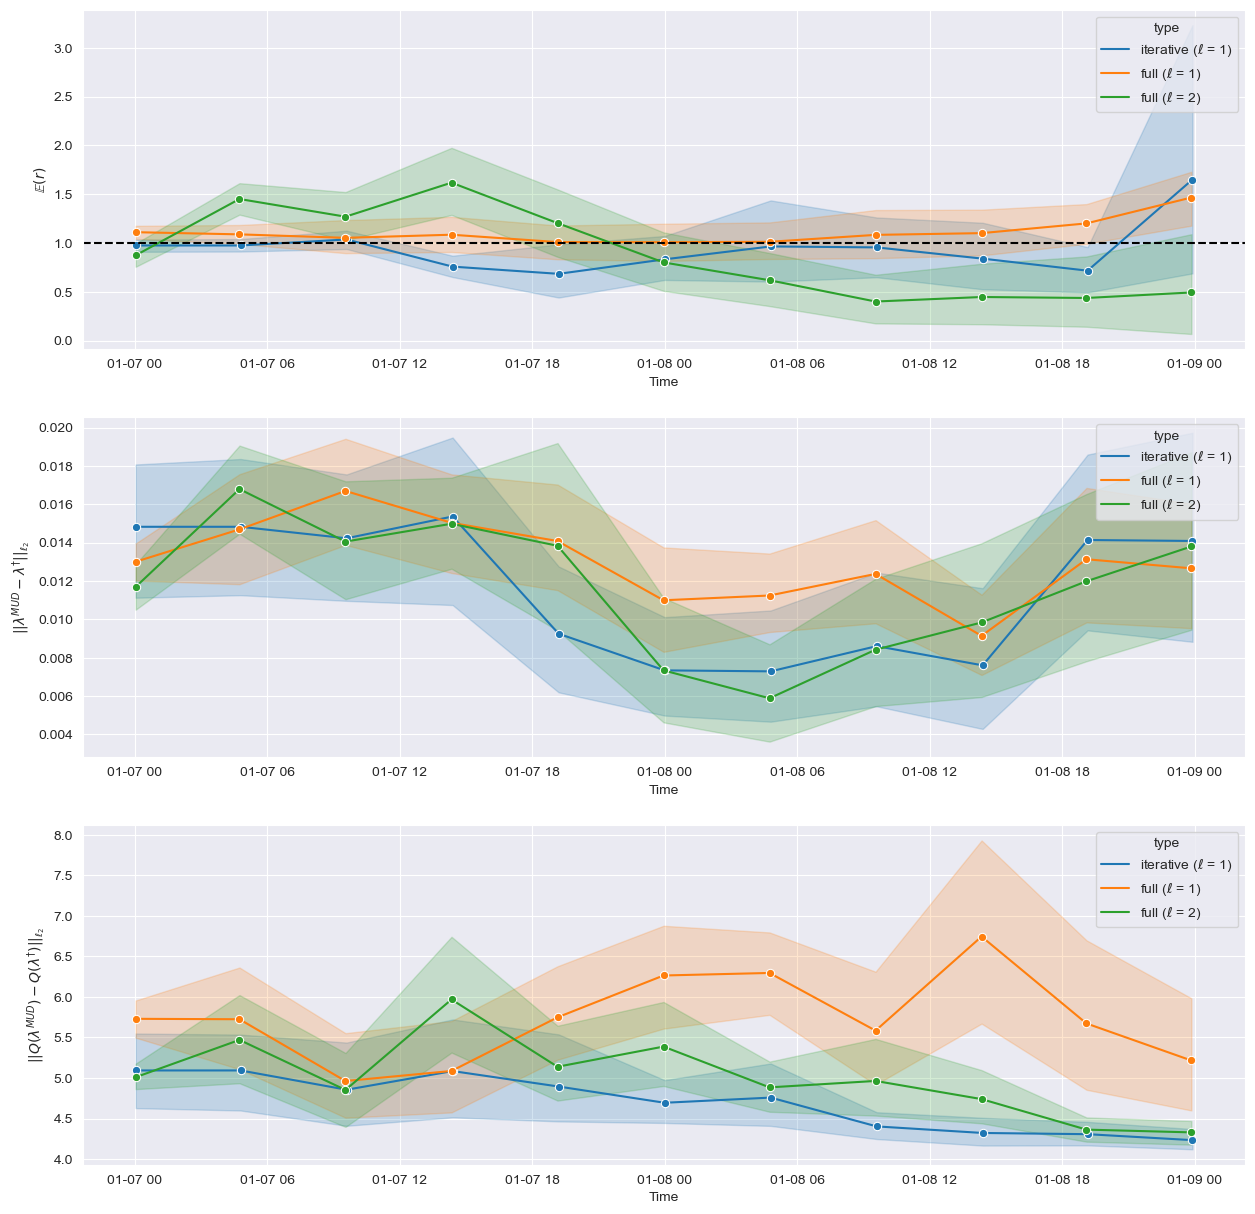

In [33]:
plot_args = {"markers": True, "hue": "type", "marker": "o"}
ax = ad.plot_metric(
    results_100,
    metric=["e_r", "l2_err", "state_err"],
    figsize=(15, 15),
    lineplot_kwargs=plot_args,
)

# Old Stuff


In [ ]:
import pdb
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pydci import PCAMUDProblem
from pydci.utils import add_noise, put_df

path = str(Path.home() / "NHERI-Published/PRJ-3492/si-inlet-full-ds.pickle")
path = str(Path.cwd() / "si-inlet-full-ds.pickle")

with open(path, "rb") as fp:
    full_ds = pickle.load(fp)

all_lam = np.vstack([full_ds["lam"], lam_ref.reshape(1, -1)])
all_data = np.vstack([full_ds["data"], full_ds["true_vals"].reshape(1, -1)])
all_lam.shape, all_data.shape


def plot_state(data, samples=None, mask=None, plot_intervals=None):
    """
    Plots the true state, observed state, and samples of the state, with
    state being the observed water level at the recording station in the grid.

    Parameters
    ----------
    samples : pd.DataFrame
        Samples from the initial distribution of parameter samples, and their
        associated states, that is water levels.
    mask : list
        List of indices to plot from the data.
    plot_intervals : list
        List of tuples, where each tuple is a name, a dictionary of arguments
        to to pass to ax.axvline, and a list of intervals to plot, intervals
        being a tuploe of tuples of start and end indices.

    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))

    mask = data.index.values if mask is None else mask
    sns.lineplot(data.iloc[mask], x="ts", y="q_lam_true_0", label="True State", ax=ax)
    sns.scatterplot(
        data.iloc[mask],
        x="ts",
        y="q_lam_obs_0",
        marker="*",
        label="Observed State",
        ax=ax,
    )

    if samples is not None:
        cols = [
            c
            for c in samples.columns
            if c.startswith("q_lam_") and int(c.split("_")[-1]) in mask
        ]
        num_plot = 10
        for idx, i in enumerate(
            np.random.choice(range(len(samples)), num_plot, replace=False)
        ):
            to_plot = pd.DataFrame(
                samples.iloc[[i]][cols].values.T, columns=[f"q_lam_s={i}"]
            )
            to_plot["ts"] = data.iloc[mask]["ts"].values
            label = None if idx != num_plot - 1 else "Samples"
            sns.lineplot(
                to_plot,
                x="ts",
                y=f"q_lam_s={i}",
                ax=ax,
                color="r",
                alpha=0.1,
                label=label,
            )

    plot_intervals = [] if plot_intervals is None else plot_intervals
    for name, args, intervals in plot_intervals:
        for interval in intervals:
            ax.axvline(data["ts"][interval[0]], **args)
        args["label"] = name
        ax.axvline(data["ts"][intervals[-1][-1]], **args)

    # ax.set_title('Time Window 3')
    # ax.set_title(f'lam_true = {data["lam_true_0"].values[0]}, {data["lam_true_1"].values[0]}')
    ax.set_ylabel("Water Elevation (m)")
    ax.set_xlabel("Time")
    ax.legend()

    return ax


def plot_iterations(prob, max_plot=10, plot_idxs=None, lam_true=None):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    if plot_idxs is None:
        num_its = prob.pca_states["iteration"].max()
        if num_its > max_plot:
            plot_idxs = list(range(0, num_its, int(num_its / max_plot)))
            if (num_its - 1) not in plot_idxs:
                plot_idxs += [num_its - 1]
        else:
            plot_idxs = range(0, num_its)

    label = f"$\pi^{{in}}_{0}$"
    sns.kdeplot(prob.state, x="lam_0", ax=ax[0], label=label)
    sns.kdeplot(prob.state, x="lam_1", ax=ax[1], label=label)
    for idx, state in prob.pca_states.groupby("iteration"):
        if idx in plot_idxs:
            label = f"$\pi^{{up}}_{{{idx}}}$"
            sns.kdeplot(
                state,
                x="lam_0",
                weights=state["weight"] * state["ratio"],
                ax=ax[0],
                label=label,
            )
            sns.kdeplot(
                state,
                x="lam_1",
                weights=state["weight"] * state["ratio"],
                ax=ax[1],
                label=label,
            )

    if lam_true is not None:
        ax[0].axvline(
            lam_true[0], color="k", linestyle="--", label=f"$\lambda^{{\dagger}}$"
        )
        ax[1].axvline(
            lam_true[1], color="k", linestyle="--", label=f"$\lambda^{{\dagger}}$"
        )

    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel("$\lambda_1$")
    ax[1].set_xlabel("$\lambda_2$")

## Repeating Trials

In [ ]:
import importlib

from alive_progress import alive_bar
from pydci.consistent_bayes import PCAMUDProblem
from pydci.log import disable_log, enable_log, logger
from pydci.utils import get_df

importlib.reload(PCAMUDProblem)


def process_result(prob, lam_true):
    # Calculate L2 error and Covariance for each
    res = prob.it_results.copy()
    mud_points = get_df(prob.it_results, "lam_MUD", 2)
    l2_errs = np.linalg.norm(mud_points - lam_true, axis=1)
    l2_errs = np.linalg.norm(mud_points - lam_true, axis=1)
    covs = []
    res["l2_err"] = l2_errs

    # Get covariance
    if not any(prob.pca_states["ratio"] == 0.0):
        lam_matrix = get_df(prob.state, "lam", 2)
        for idx, state in prob.pca_states.groupby("iteration"):
            cov = np.cov(lam_matrix.T, aweights=state["ratio"])
            covs.append([cov[0][0], cov[1][1]])
        covs = np.array(covs)
        res["lam_0_cov"] = covs[:, 0]
        res["lam_1_cov"] = covs[:, 1]
    else:
        res["lam_0_cov"] = np.nan
        res["lam_1_cov"] = np.nan

    mud_states = get_df(
        prob.state.iloc[prob.it_results["MUD_idx"].values], "q_lam", prob.n_qoi
    )
    res["state_err"] = np.linalg.norm((mud_states.T - measurements).T, axis=1)

    res["i"] = res["i"] + 1
    res["ts"] = [
        full_ds["times"][int(x.split(",")[-1][1:-1])] for x in res["pca_mask"].values
    ]
    first = res.iloc[[0]].copy()
    first["i"] = 0
    first["ts"] = [full_ds["times"][eval(res["pca_mask"].values[0])[0]]]
    res = pd.concat([first, res])
    res["splits"] = res["i"].max()
    res["n_samples"] = prob.n_samples
    return res


def split_sVcan(
    ds,
    n_splits,
    std_dev=0.05,
    num_samples=[999],
    pca_components=[[0]],
    n_trials=10
):
    all_results = []

    with alive_bar(
        n_trials * len(num_samples) * len(n_splits),
        title=f"Scanning {n_splits} using {num_samples}",
        force_tty=True,
    ) as bar:
        for n in range(n_trials):
            for n_samples in num_samples:
                ret = ad.build_ds(
                    data=ds,
                    std_dev=std_dev, num_samples=n_samples
                )
                for ns in n_splits:
                    pca = PCAMUDProblem.PCAMUDProblem(ret['samples'], ret['data'], std_dev)
                    pca.solve_it(
                        pca_mask=t3_mask
                        pca_splits=ns,
                        pca_components=pca_components,
                        exp_thresh=1e10,
                    )
                    res = process_result(pca, lam_ref)
                    res['n_iters'] = ns
                    all_results.append(res)
                    bar()

    all_results = pd.concat(all_results)

    return all_results


def incremental_scan(
    num_splits=100,
    std_dev=0.05,
    num_samples=[999],
    exp_thresh=1e10,
    pca_components=[[0, 1]],
    n_trials=10,
):
    all_results = []

    with alive_bar(
        n_trials * len(num_samples) * num_splits,
        title=f"Scanning {num_splits} using {num_samples}",
        force_tty=True,
    ) as bar:
        for n in range(n_trials):
            for n_samples in num_samples:
                data_df, samples_df, measurements = build_dataset(
                    std_dev=std_dev, num_samples=n_samples
                )
                intervals = split_range(t3_mask, num_splits)
                start = intervals[0][0]
                for interval in intervals:
                    pca = PCAMUDProblem.PCAMUDProblem(samples_df, measurements, std_dev)
                    pca.solve_it(
                        pca_splits=[range(start, max(interval))],
                        pca_components=pca_components,
                        exp_thresh=1e10,
                    )
                    all_results.append(process_result(pca, lam_ref))
                    all_results[-1]['n_iters'] = 1
                    bar()

    all_results = pd.concat(all_results)

    return all_results

def plot_metric(results, metric='e_r'):
    """
    Plot metric for scan results over time.
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    results = results[
        [c for c in results.columns if c in ["i", "ts", "n_iters", "n_samples", metric]]
    ].copy()
    col_name = '(# splits, # samples)'
    results.loc[:,col_name] = [f'({x[0], x[1]})' for x in zip(results['n_iters'], results['n_samples'])]
    sns.lineplot(
        results.dropna(),
        markers=True,
        x='ts', y=metric,
        ax=ax,
        style=col_name,
        hue=col_name,
        palette='flare')
    ax.set_xlabel('Time')
    metric_labels = {
        'e_r': "$\mathbb{E}(r)$",
        'kl': "$\mathcal{D}_{KL}$",
        'l2_err': "$||\lambda^{MUD} - \lambda^{\dagger}||_{\ell_2}$",
        'state_err': "$||Q(\lambda^{MUD}) - Q(\lambda^{\dagger})||_{\ell_2}$",
        'lam_0_cov': "$\sigma_0$",
        'lam_1_cov': "$\sigma_1$",
    }
    ax.set_ylabel(metric_labels[metric])

In [ ]:
from typing import List


def process_result(prob, lam_true):
    """
    Further processes ther result of an iterative PCAMUDProblem,
    that is solved by `solve_it`, by doing the following:

    1. Calculating l2_err according to true value passed in
    2. Calculating state error, where state here is defined as
    the learned qoi from the PCA map, not the true time series values.
    3.
    """

    # Calculate L2 error and Covariance for each
    res = prob.it_results.copy()
    mud_points = get_df(prob.it_results, "lam_MUD", 2)
    l2_errs = np.linalg.norm(mud_points - lam_true, axis=1)
    l2_errs = np.linalg.norm(mud_points - lam_true, axis=1)
    covs = []
    res["l2_err"] = l2_errs

    mud_states = get_df(
        prob.state.iloc[prob.it_results["MUD_idx"].values], "q_lam", prob.n_qoi
    )
    res["state_err"] = np.linalg.norm((mud_states.T - prob.data).T, axis=1)

    res["ts"] = [
        data_df["ts"][int(x.split(",")[-1][1:-1])] for x in res["pca_mask"].values
    ]

    res["i"] = res["i"] + 1
    first = res.iloc[[0]].copy()
    first["i"] = 0
    first["ts"] = [data_df["ts"][eval(res["pca_mask"].values[0])[0]]]
    res = pd.concat([first, res])

    res["max_it"] = res["i"].max()

    return res


def iterative_trials(
    ds: np.ndarray,
    num_splits: int = 10,
    std_dev: float = 0.05,
    num_samples: int = 999,
    pca_components: List[List[int]] = [[0]],
    num_trials: int = 10,
) -> pd.DataFrame:
    """
    Perform iterative trials.

    Iterative trials are staged as the following:
    For each trial, there are the following parameters:
    - Number of samples
    - Number of splits

    Each trial is performed by first sampling the dataset, using the provided parameters.

    Parameters:
    -----------
    ds : numpy.ndarray
        Input full dataset, as loaded by `pydci.examples.adcirc.load_full_ds`.
    num_splits : int
        Number of splits to use or a list of numbers of splits for iterations.
        Default is 10.
    std_dev : float, optional
        Standard deviation value. Default is 0.05.
    num_samples : int
        List of numbers of samples. Default is [999].
    pca_components : list of list of int, optional
        List of PCA components. Default is [[0]].
    num_trials : int, optional
        Number of trials. Default is 10.

    Returns:
    --------
    pandas.DataFrame
        Results of the iterative trials.
    """

    all_results = []
    nc = len(pca_components[0])
    with alive_bar(
        num_trials,
        title=f"Iterative (nc = {len(pca_components[0])})",
        force_tty=True,
        length=20,
    ) as bar:
        for n in range(num_trials):
            ret = ad.build_ds(data=ds, std_dev=std_dev, num_samples=num_samples)
            pca = PCAMUDProblem(ret["samples"], ret["data"], std_dev)
            pca.solve_it(
                pca_mask=t3_mask,
                pca_splits=num_splits,
                pca_components=pca_components,
                exp_thresh=1e10,
            )
            res = process_result(pca, lam_ref)
            res["num_iters"] = num_splits
            res["trial"] = n
            res["type"] = f"iterative ($\ell$ = {len(pca_components[0])})"
            all_results.append(res)
            bar()

    all_results = pd.concat(all_results)

    return all_results


def fixed_trials(
    ds: np.ndarray,
    num_splits: int = 10,
    std_dev: float = 0.05,
    num_samples: int = 999,
    exp_thresh: float = 1e10,
    pca_components: List[List[int]] = [[0]],
    num_trials: int = 10,
) -> pd.DataFrame:
    """
    Perform fixed trials.

    Fixed trials are performed by splitting the dataset into fixed intervals and solving
    the problem for each interval separately.

    Parameters:
    -----------
    ds : numpy.ndarray
        Input full dataset, as loaded by `pydci.examples.adcirc.load_full_ds`.
    num_splits : int
        Number of splits to use or a list of numbers of splits for iterations.
        Default is 10.
    std_dev : float, optional
        Standard deviation value. Default is 0.05.
    num_samples : int, optional
        Number of samples. Default is 999.
    exp_thresh : float, optional
        Threshold for exponential value. Default is 1e10.
    pca_components : list of list of int, optional
        List of PCA components. Default is [[0]].
    num_trials : int, optional
        Number of trials. Default is 10.

    Returns:
    --------
    pandas.DataFrame
        Results of the fixed trials.
    """
    all_results = []

    with alive_bar(
        num_trials * num_splits,
        title=f"Full (nc = {len(pca_components[0])})",
        force_tty=True,
        length=20,
    ) as bar:
        for n in range(num_trials):
            ret = ad.build_ds(data=ds, std_dev=std_dev, num_samples=num_samples)
            intervals = [
                range(t3_mask[0], x[-1]) for x in np.array_split(t3_mask, num_splits)
            ]
            for interval in intervals:
                pca = PCAMUDProblem(ret["samples"], ret["data"], std_dev)
                pca.solve_it(
                    pca_mask=interval,
                    pca_splits=1,
                    pca_components=pca_components,
                    exp_thresh=1e10,
                )
                all_results.append(process_result(pca, lam_ref))
                all_results[-1]["trial"] = n
                all_results[-1]["num_iters"] = num_splits
                all_results[-1]["type"] = f"full ($\ell$ = {len(pca_components[0])})"
                bar()

    all_results = pd.concat(all_results)

    return all_results


def plot_metric(results, metric="e_r", figsize=(12, 5), ax=None, lineplot_kwargs=None):
    """
    Plot metric for scan results over time.
    """
    results = pd.concat(results) if isinstance(results, list) else results
    metric = [metric] if isinstance(metric, str) else metric
    if ax is None:
        fig, ax = plt.subplots(len(metric), 1, figsize=figsize)
    else:
        ax = [ax] if isinstance(ax, plt.Axes) else ax
        if len(ax) != len(metric):
            raise ValueError("Number of axes must match number of metrics")

    metric_labels = {
        "e_r": "$\mathbb{E}(r)$",
        "kl": "$\mathcal{D}_{KL}$",
        "l2_err": "$||\lambda^{MUD} - \lambda^{\dagger}||_{\ell_2}$",
        "state_err": "$||Q(\lambda^{MUD}) - Q(\lambda^{\dagger})||_{\ell_2}$",
    }
    metric_ttiles = {
        "e_r": "Predictability Assumption",
        "kl": "$\mathcal{D}_{KL}$",
        "l2_err": "$||\lambda^{MUD} - \lambda^{\dagger}||_{\ell_2}$",
        "state_err": "$||Q(\lambda^{MUD}) - Q(\lambda^{\dagger})||_{\ell_2}$",
    }
    results = results[
        [c for c in results.columns if c in ["i", "ts", "n_iters", "type"] + metric]
    ].copy()
    def_kwargs = {"x": "ts"}
    def_kwargs.update(lineplot_kwargs or {})
    for i, mc in enumerate(metric):
        def_kwargs["y"] = mc
        def_kwargs["ax"] = ax[i]
        sns.lineplot(results.dropna(), **def_kwargs)
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel(metric_labels[mc])

        if mc == "e_r":
            ax[i].axhline(y=1, color="black", linestyle="--")
            # ax[i].hlines(1, *ax[i].get_xlim(), color='red', linestyle='--')

    return ax

In [ ]:
data_df

,ts,shift_idx,sample_flag,lam_true_0,lam_true_1,q_lam_true_0,q_lam_obs_0
0,2018-01-01 00:03:00,0,True,0.067243,0.002568,-0.160002,-0.162600
1,2018-01-01 00:06:00,0,True,0.067243,0.002568,-0.159192,-0.164751
2,2018-01-01 00:09:00,0,True,0.067243,0.002568,-0.158108,-0.106019
3,2018-01-01 00:12:00,0,True,0.067243,0.002568,-0.156425,-0.219262
4,2018-01-01 00:15:00,0,True,0.067243,0.002568,-0.154186,-0.116916
...,...,...,...,...,...,...,...
6128,2018-01-13 23:45:00,0,True,0.067243,0.002568,-0.156296,-0.126368
6129,2018-01-13 23:48:00,0,True,0.067243,0.002568,-0.167302,-0.212053
6130,2018-01-13 23:51:00,0,True,0.067243,0.002568,-0.178476,-0.254657
6131,2018-01-13 23:54:00,0,True,0.067243,0.002568,-0.189576,-0.240698


In [ ]:
split_results = split_scan(
    n_splits=[10, 100],
    std_dev=std_dev,
    n_trials=10,
    num_samples=[999],
    pca_components=[[0]],
)

In [ ]:
import pdb
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pydci import PCAMUDProblem
from pydci.utils import add_noise, put_df

path = str(Path.home() / "NHERI-Published/PRJ-3492/si-inlet-full-ds.pickle")
path = str(Path.cwd() / "si-inlet-full-ds.pickle")

with open(path, "rb") as fp:
    full_ds = pickle.load(fp)

all_lam = np.vstack([full_ds["lam"], lam_ref.reshape(1, -1)])
all_data = np.vstack([full_ds["data"], full_ds["true_vals"].reshape(1, -1)])
all_lam.shape, all_data.shape


def plot_state(data, samples=None, mask=None, plot_intervals=None):
    """
    Plots the true state, observed state, and samples of the state, with
    state being the observed water level at the recording station in the grid.

    Parameters
    ----------
    samples : pd.DataFrame
        Samples from the initial distribution of parameter samples, and their
        associated states, that is water levels.
    mask : list
        List of indices to plot from the data.
    plot_intervals : list
        List of tuples, where each tuple is a name, a dictionary of arguments
        to to pass to ax.axvline, and a list of intervals to plot, intervals
        being a tuploe of tuples of start and end indices.

    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))

    mask = data.index.values if mask is None else mask
    sns.lineplot(data.iloc[mask], x="ts", y="q_lam_true_0", label="True State", ax=ax)
    sns.scatterplot(
        data.iloc[mask],
        x="ts",
        y="q_lam_obs_0",
        marker="*",
        label="Observed State",
        ax=ax,
    )

    if samples is not None:
        cols = [
            c
            for c in samples.columns
            if c.startswith("q_lam_") and int(c.split("_")[-1]) in mask
        ]
        num_plot = 10
        for idx, i in enumerate(
            np.random.choice(range(len(samples)), num_plot, replace=False)
        ):
            to_plot = pd.DataFrame(
                samples.iloc[[i]][cols].values.T, columns=[f"q_lam_s={i}"]
            )
            to_plot["ts"] = data.iloc[mask]["ts"].values
            label = None if idx != num_plot - 1 else "Samples"
            sns.lineplot(
                to_plot,
                x="ts",
                y=f"q_lam_s={i}",
                ax=ax,
                color="r",
                alpha=0.1,
                label=label,
            )

    plot_intervals = [] if plot_intervals is None else plot_intervals
    for name, args, intervals in plot_intervals:
        for interval in intervals:
            ax.axvline(data["ts"][interval[0]], **args)
        args["label"] = name
        ax.axvline(data["ts"][intervals[-1][-1]], **args)

    # ax.set_title('Time Window 3')
    # ax.set_title(f'lam_true = {data["lam_true_0"].values[0]}, {data["lam_true_1"].values[0]}')
    ax.set_ylabel("Water Elevation (m)")
    ax.set_xlabel("Time")
    ax.legend()

    return ax


def plot_iterations(prob, max_plot=10, plot_idxs=None, lam_true=None):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    if plot_idxs is None:
        num_its = prob.pca_states["iteration"].max()
        if num_its > max_plot:
            plot_idxs = list(range(0, num_its, int(num_its / max_plot)))
            if (num_its - 1) not in plot_idxs:
                plot_idxs += [num_its - 1]
        else:
            plot_idxs = range(0, num_its)

    label = f"$\pi^{{in}}_{0}$"
    sns.kdeplot(prob.state, x="lam_0", ax=ax[0], label=label)
    sns.kdeplot(prob.state, x="lam_1", ax=ax[1], label=label)
    for idx, state in prob.pca_states.groupby("iteration"):
        if idx in plot_idxs:
            label = f"$\pi^{{up}}_{{{idx}}}$"
            sns.kdeplot(
                state,
                x="lam_0",
                weights=state["weight"] * state["ratio"],
                ax=ax[0],
                label=label,
            )
            sns.kdeplot(
                state,
                x="lam_1",
                weights=state["weight"] * state["ratio"],
                ax=ax[1],
                label=label,
            )

    if lam_true is not None:
        ax[0].axvline(
            lam_true[0], color="k", linestyle="--", label=f"$\lambda^{{\dagger}}$"
        )
        ax[1].axvline(
            lam_true[1], color="k", linestyle="--", label=f"$\lambda^{{\dagger}}$"
        )

    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel("$\lambda_1$")
    ax[1].set_xlabel("$\lambda_2$")

In [ ]:
inc_scan = incremental_scan(
    num_splits=50, std_dev=std_dev, n_trials=10, num_samples=[10, 100, 999]
)

In [ ]:
all_results = pd.concat([inc_scan, split_results])
all_results

In [ ]:
# TODO: Change legend labels -> Stress 1 split uses 2 component map.
plot_metric(
    all_results[
        ((all_results["splits"] == 1) | (all_results["splits"] == 100))
        & ((all_results["n_samples"] == 100) | (all_results["n_samples"] == 999))
    ],
    metric="e_r",
)

In [ ]:
plot_metric(
    all_results[
        ((all_results["splits"] == 1) | (all_results["splits"] == 100))
        & ((all_results["n_samples"] == 100) | (all_results["n_samples"] == 999))
    ],
    metric="kl",
)

In [ ]:
plot_metric(
    all_results[
        ((all_results["splits"] == 1) | (all_results["splits"] == 100))
        & ((all_results["n_samples"] == 100) | (all_results["n_samples"] == 999))
    ],
    metric="l2_err",
)

In [ ]:
plot_metric(
    all_results[
        ((all_results["splits"] == 1) | (all_results["splits"] == 100))
        & ((all_results["n_samples"] == 100) | (all_results["n_samples"] == 999))
    ].dropna(),
    metric="state_err",
)

In [ ]:
plot_metric(
    all_results[
        ((all_results["splits"] == 1) | (all_results["splits"] == 100))
        & ((all_results["n_samples"] == 100) | (all_results["n_samples"] == 999))
    ].dropna(),
    metric="lam_0_cov",
)

In [ ]:
plot_metric(
    all_results[
        ((all_results["splits"] == 1) | (all_results["splits"] == 100))
        & ((all_results["n_samples"] == 100) | (all_results["n_samples"] == 999))
    ].dropna(),
    metric="lam_1_cov",
)

## Selective Intervals

Using weights only from intervals with good E(r) values.

In [ ]:
thresh = 0.95
good_e_r = pca_100.it_results["i"][
    (pca_100.it_results["e_r"] > 1 - thresh) & (pca_100.it_results["e_r"] < 1 + thresh)
].values
weights = []
for gi in good_e_r:
    weights.append(
        pca_100.pca_states[pca_100.pca_states["iteration"] == gi]["ratio"].values
    )

mud_pt = get_df(
    pca_100.state.iloc[[np.argmax(np.prod(np.array(weights), axis=0))]], "lam", 2
)

In [ ]:
sns.kdeplot(data=pca_100.state, x="lam_0", weights=np.prod(np.array(weights), axis=0))

In [ ]:
sns.kdeplot(data=pca_100.state, x="lam_1", weights=np.prod(np.array(weights), axis=0))

In [ ]:
ratios = (
    pca_100.pca_states[["ratio"]]
    .iloc[[x in good_e_r for x in pca_100.pca_states["iteration"]]]
    .values.reshape(pca_100.n_samples, len(good_e_r))
    .T
)

In [ ]:
sns.kdeplot(
    data=pca_100.pca_states[pca_100.pca_states["iteration"] == 0],
    x="lam_0",
    weights="ratio",
)

In [ ]:
sns.kdeplot(
    data=pca_100.pca_states[pca_100.pca_states["iteration"] == 0],
    x="lam_0",
    weights=ratios[0],
)

In [ ]:
cols = ["ts", "splits", "n_samples"]
metrics = ["e_r", "kl", "l2_err"]
all_dfs = []
for metric in metrics:
    df = split_results[cols].copy()
    df["metric_val"] = split_results[metric].values
    df["metric"] = metric
    all_dfs.append(df)

all_dfs = pd.concat(all_dfs).dropna()
all_dfs["(# splits, # samples)"] = [
    f"({x[0]},{x[1]})"
    for x in zip(all_dfs["splits"].values, all_dfs["n_samples"].values)
]
all_dfs